### 회귀 실습  - 캐글 주택 가격: 고급 회귀 기법

- 본 경연에서는 RMSE로 성능을 평가하되 예측값과 실제값의 로그 변환을 기반으로 수행한다고 했으니 결론적으로는 RMSLE와 동일한 방식이다

- 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이를 상쇄하기 위해 로그 변환된 RMSLE를 이용하자

#### 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('/content/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
#타겟은 SalePrice
print('데이터셋의 shape', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수: \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터셋의 shape (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


피처 타입은 숫자형, 문자형 둘다 많고 데이터 양에 비해 null값이 많은 피처도 있다


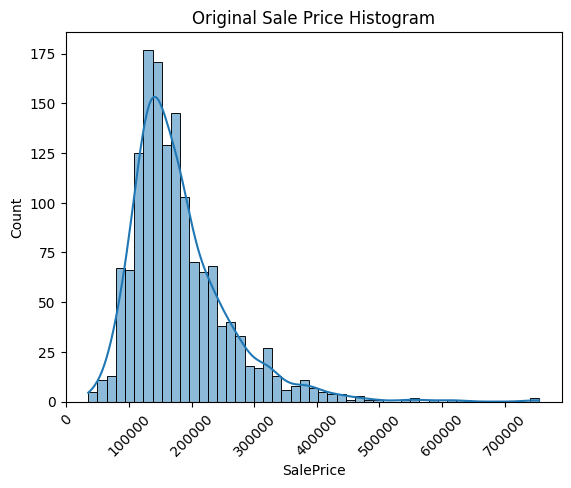

In [3]:
#회귀 모델 적용 전, 타겟값 분포도 확인
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

타겟값을 정규 분포 형태로 변환하기 위해 로그 변환 적용하자

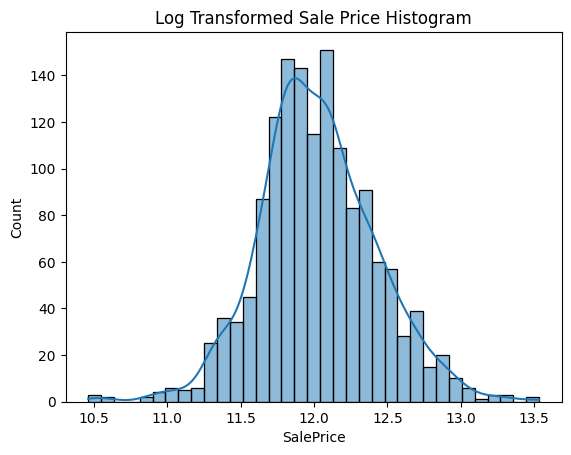

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_saleprice = np.log1p(house_df['SalePrice'])
sns.histplot(log_saleprice, kde=True)
plt.show()

In [5]:
#타겟값 로그 변환
original_saleprice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#null값이 너무 많은 피처, 불필요한 피처 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

#드랍하지 않은 숫자형 null 칼럼들은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

#null값이 있는 피처명, 타입 추출
null_col_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_col_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


이제 문자형을 제외하고는 결측치가 있는 칼럼이 없다

문자형 피처들은 원-핫 인코딩으로 변환하자, get_dummies를 이용하면 null값들을 0으로 인코딩해준다.

원-핫 인코딩을 진행하면 당연히 칼럼 개수가 늘어난다.

In [6]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_col_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_col_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type:
 Series([], dtype: object)


이제 null값을 가진 피처는 존재하지 않는다

#### 선형 회귀 모델 학습/예측/평가

- 성능 평가 시에 RMSLE를 사용한다했는데, 이미 타겟값은 로그 변환되었다.

- 예측값 역시 로그 변환된 SalePrice를 기반으로 예측하므로 원본 예측값의 로그 변환된 값이다.

- 여기서 예측 결과 오류에 RMSE를 적용하면 RMSLE가 자동으로 측정되는 것이다

In [7]:
#여러 모델의 로그 변환된 RMSE를 측정하기 위해 함수 생성

#단일 모델의 RMSE값 반환
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

#get_rmse를 이용하여 여러 모델의 RMSE를 반환
def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154297, 0.12750846334053004, 0.17628250556471403]

라쏘의 경우는 다른 회귀보다 성능이 떨어지는 결과가 나왔다.

라쏘는 최적 하이퍼 파라미터 튜닝이 필요해보인다

In [9]:
#피처별 회귀 계수 시각화, 상위 10개, 하위 10개만
def get_top_bottom_coef(model, n=10):
  #coef_ 속성을 기반으로 Series 객체 생성
  coef = pd.Series(model.coef_, index=X_features.columns)

  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

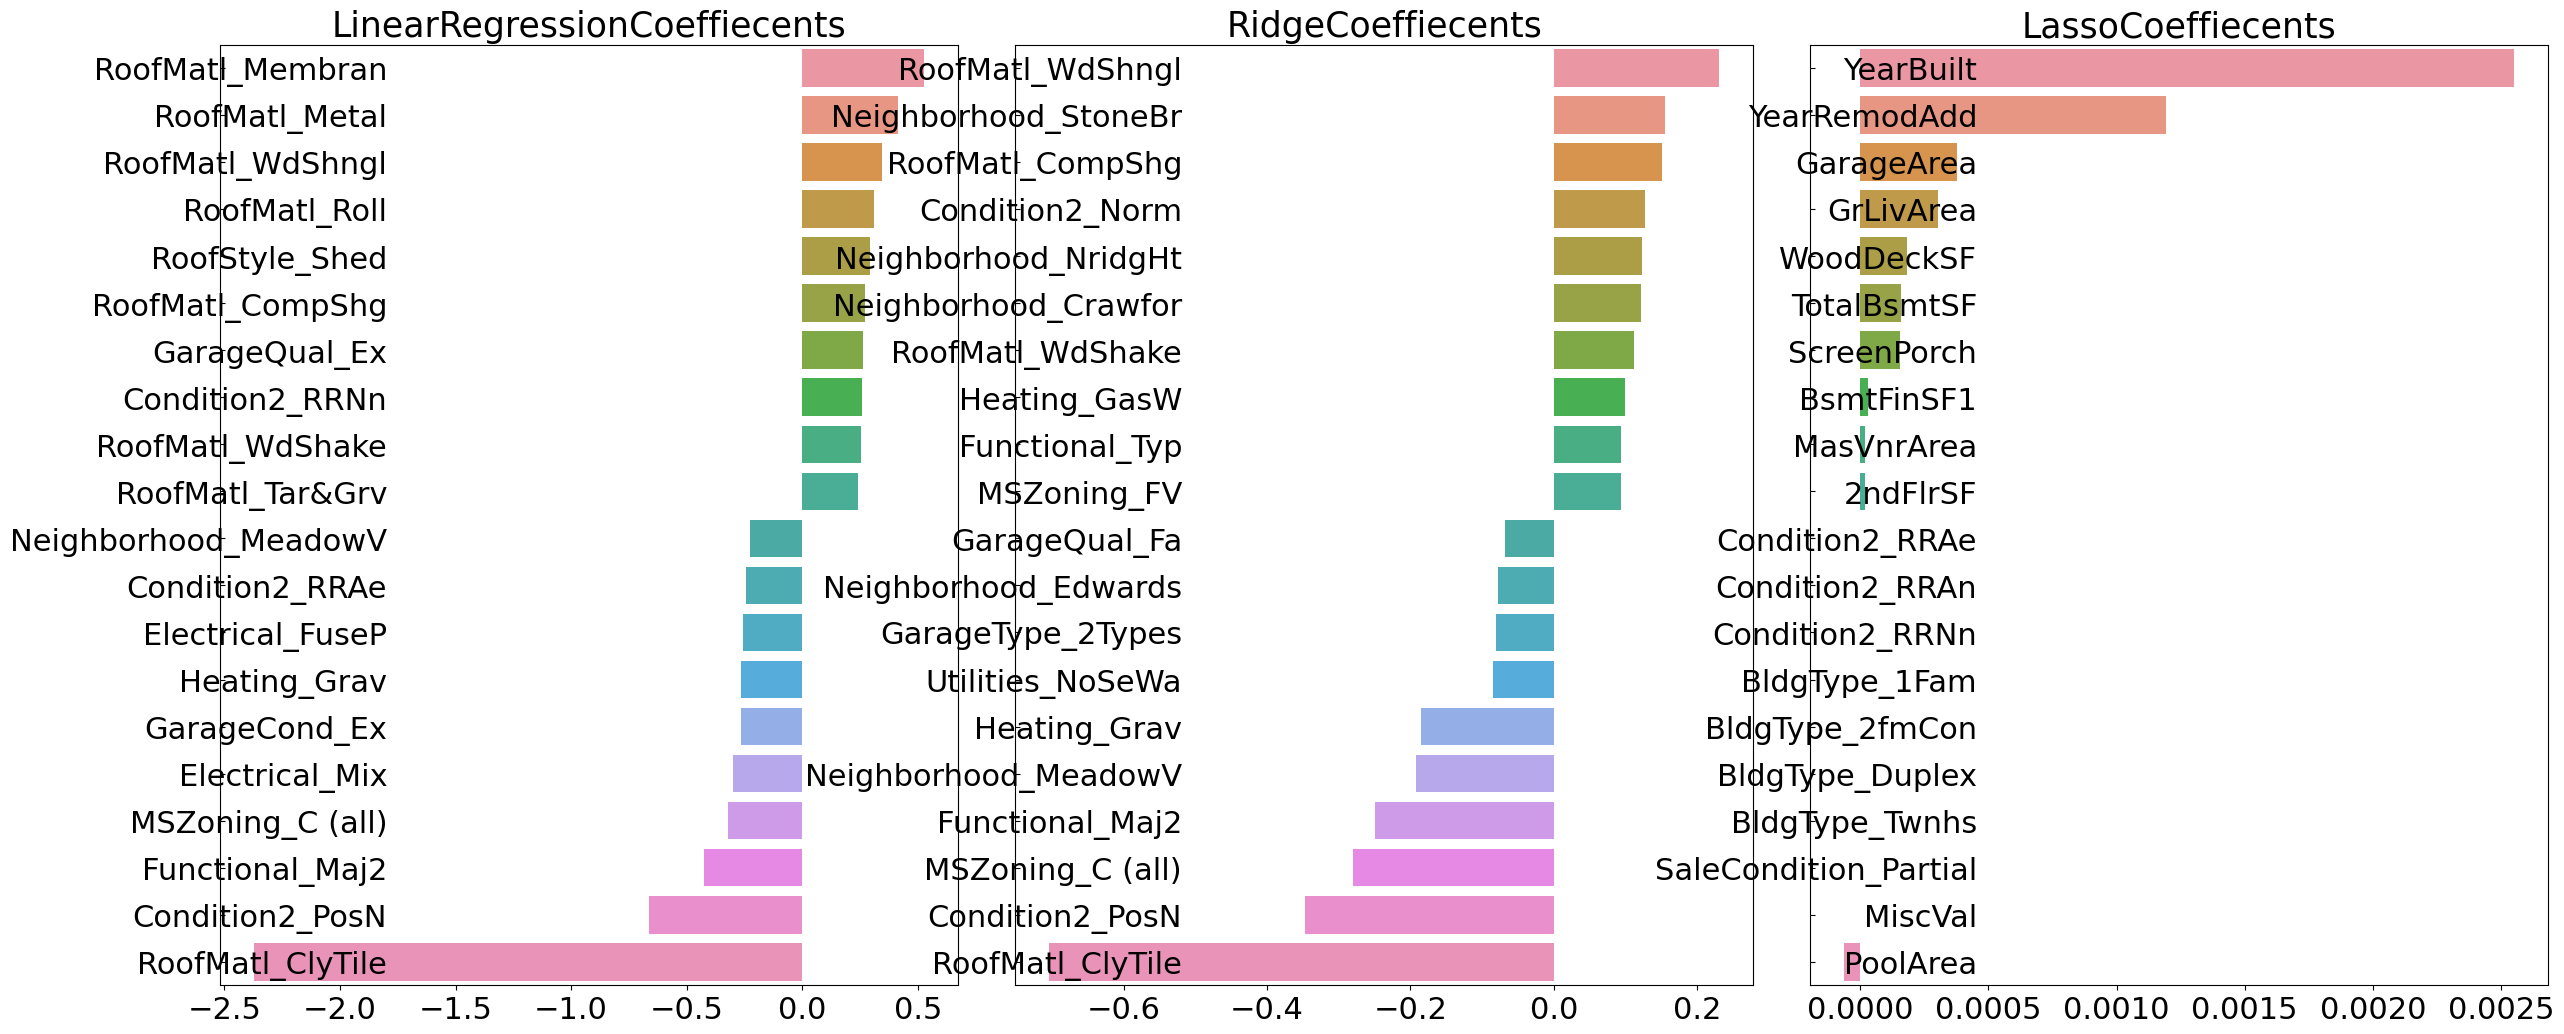

In [10]:
#시각화 위한 함수 생성, 이 함수는 list 객체로 모델을 입력받아 모델별로 상위 10개, 하위 10개를 추출한다
def visualize_coef(models):
  #모델이 3개니까 3개 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()

  for i_num, model in enumerate(models):
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    #막대그래프로 표현, 한 화면에 나타내기 위해 tick label 위치와 font 크기 조절
    axs[i_num].set_title(model.__class__.__name__+'Coeffiecents', size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coef(models)

LinearRegression과 Ridge는 회귀 계수가 유사한 형태로 분포돼있다

그러나 라쏘는 전체적으로 회귀 계수값이 매우 작고, 그 중에 GrLivArea가 가장 크고 다른 피처들은 너무 작다

학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지, 이번엔 데이터를 분할하지 않고 X_features와 y_target 전체를 5개의 교차 검증 폴드로 분할해서 진행해보자

In [11]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값:{1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값:0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값:0.198


여전히 라쏘가 릿지보다는 성능이 떨어진다

릿지와 라쏘에 alpha 파라미터를 변화시키면서 최적값을 도출해보자

In [12]:
#앞으로 모델별로 반복적인 하이퍼 파라미터 튜닝 작업을 위해 함수 생성
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params,
                            scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV시 최적 평균 RMSE값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                         np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV시 최적 평균 RMSE값:0.142, 최적 alpha:{'alpha': 0.001}


릿지의 경우 alpha가 10에서 RMSE가 0.011, 라쏘의 경우 alpha가 0.001에서 RMSE가 0.0126로 라쏘는 alpha값 최적화 이후 성능이 좋아졌다

→ 선형 모델에 최적 alpha값을 설정하고 train_test_split으로 분할된 데이터로 학습, 예측, 평가를 수행해보자

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


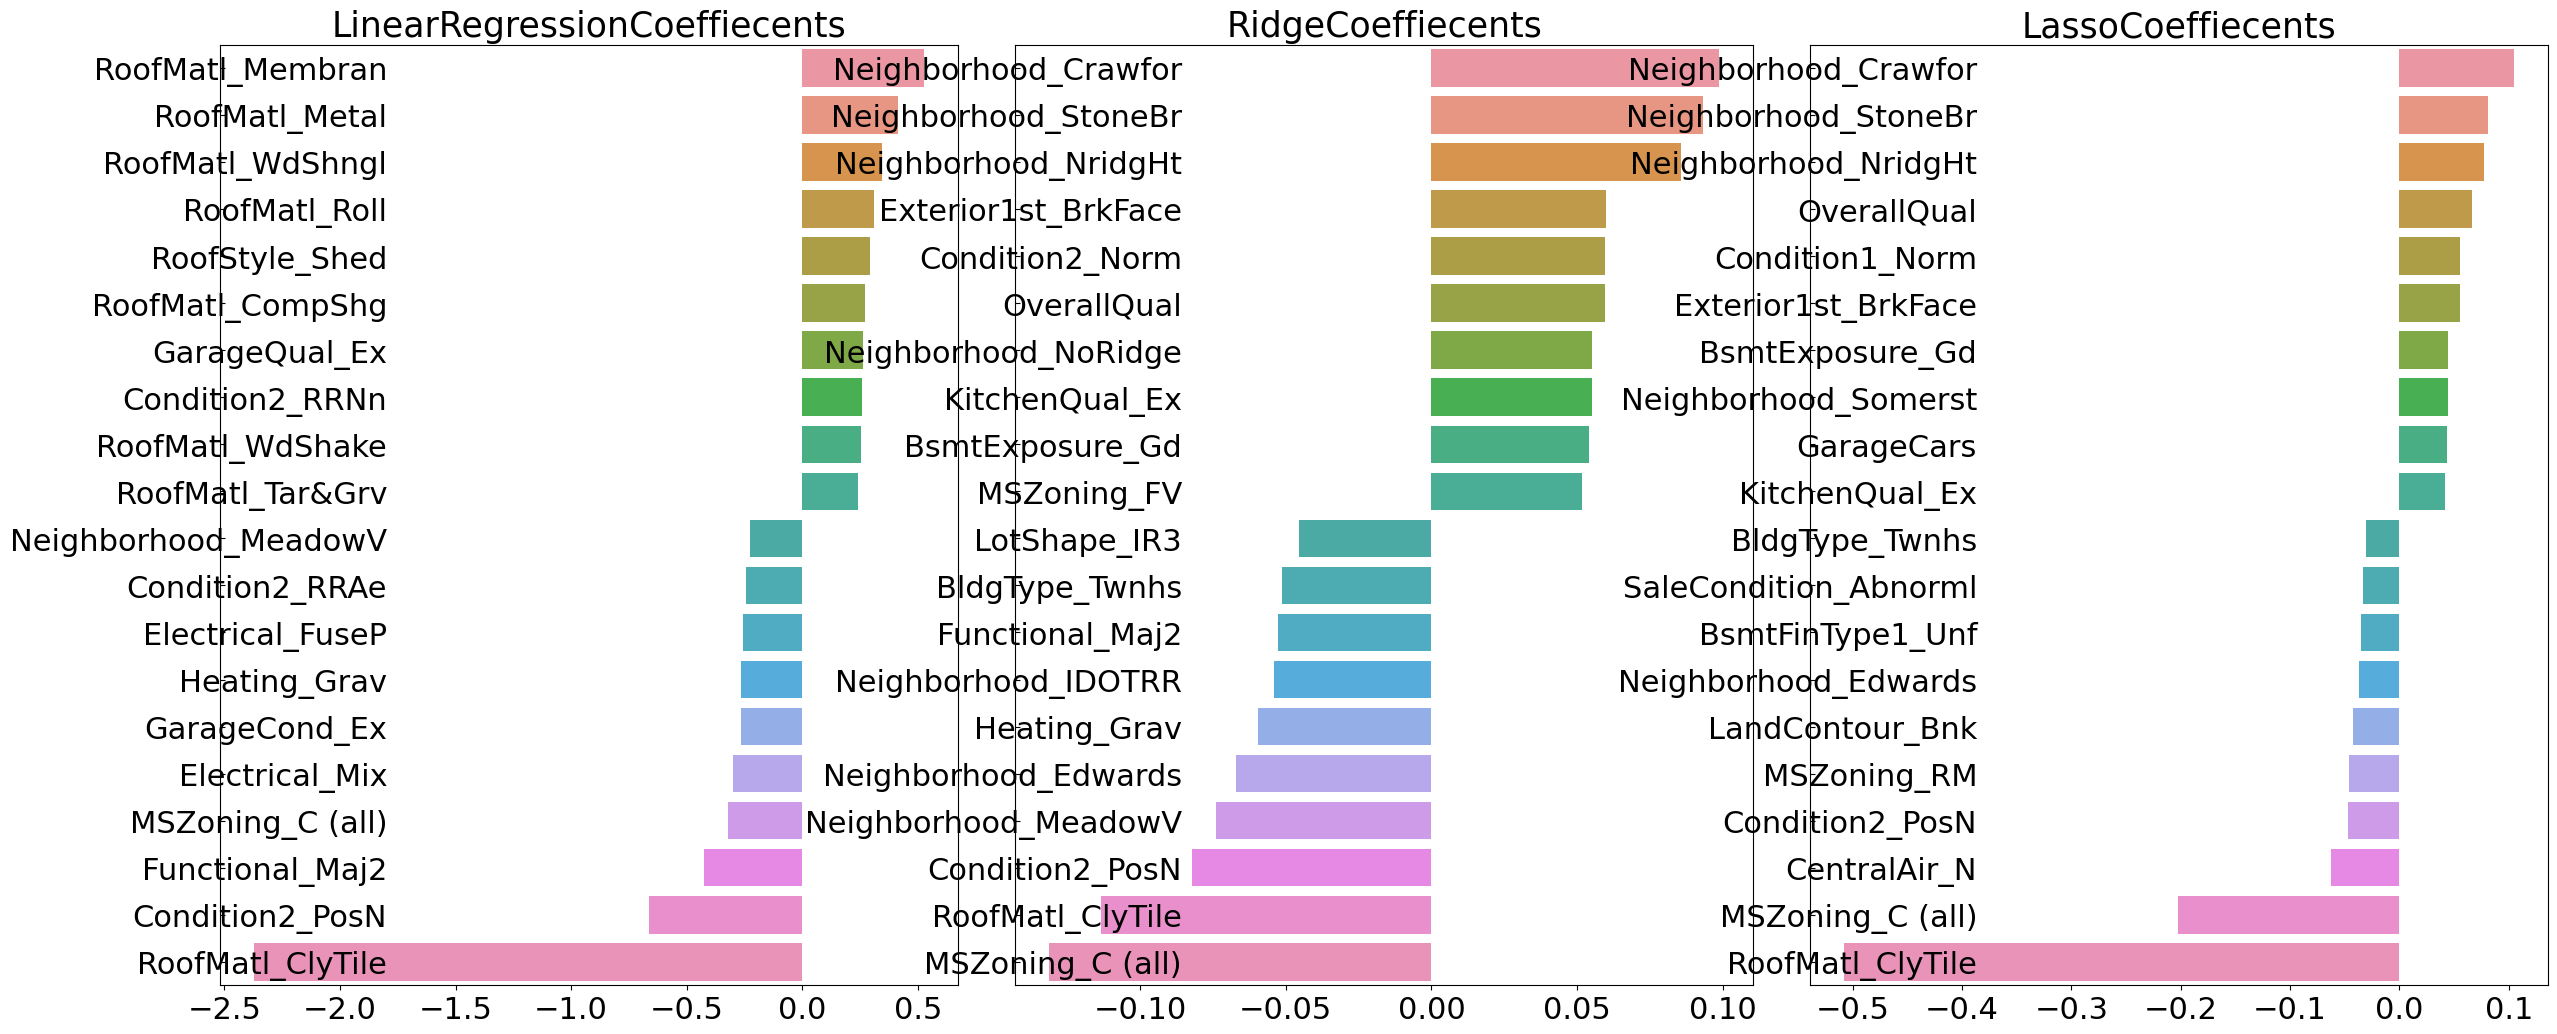

In [13]:
#최적 alpha값 적용해서 분리된 데이터로 예측 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coef(models)

alpha값 최적화 후 테스트 데이터셋의 예측 성능이 더 좋아졌다.

모델별 회귀 계수도 많이 달라졌다.

#### 모델 튜닝 더 진행해보기

1. 피처 데이터셋의 데이터 분포도 살펴보기


2. 이상치 데이터 처리

##### 1. 피처 데이터셋의 데이터 분포도 살펴보기  
  
  - 피처 데이터셋의 경우도 지나치게 왜곡된 피처가 존재하면 성능을 저하시킬 수 있음

  - 모든 숫자형 피처들의 분포도 확인하기

  - scipy의 stats모듈 skew() 함수를 이용하여 왜곡된 정도를 쉽게 추출할 수 있음

  - skew()의 반환값이 1 이상이면 왜곡 정도가 높다고 판단하지만 상황에 따라 편차가 있음 >> 1 이상의 값을 반환하는 피처만 추출하여 왜곡 정도를 완화하기 위해 로그 변환을 적용하자

  - skew()를 적용하는 숫자형 피처에 원-핫 인코딩된 범주형 숫자 피처는 제외해야 한다 >> 범주형 피처는 코드성 피처이므로 인코딩시 당연히 왜곡될 가능성이 높다

  - 따라서 house_df_ohe말고 house_df에 skew()를 적용해야 함

In [14]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

#house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터셋 반환, apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [15]:
#왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

house_df의 피처를 일부 로그 변환했으니 다시 원-핫 인코딩을 적용한 house_df_ohe 만들기

이에 기반한 피처 데이터셋, 타겟 데이터셋, 학습/테스트 데이터셋 모두 다시 만들기

In [16]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV시 최적 평균 RMSE값:0.1252, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


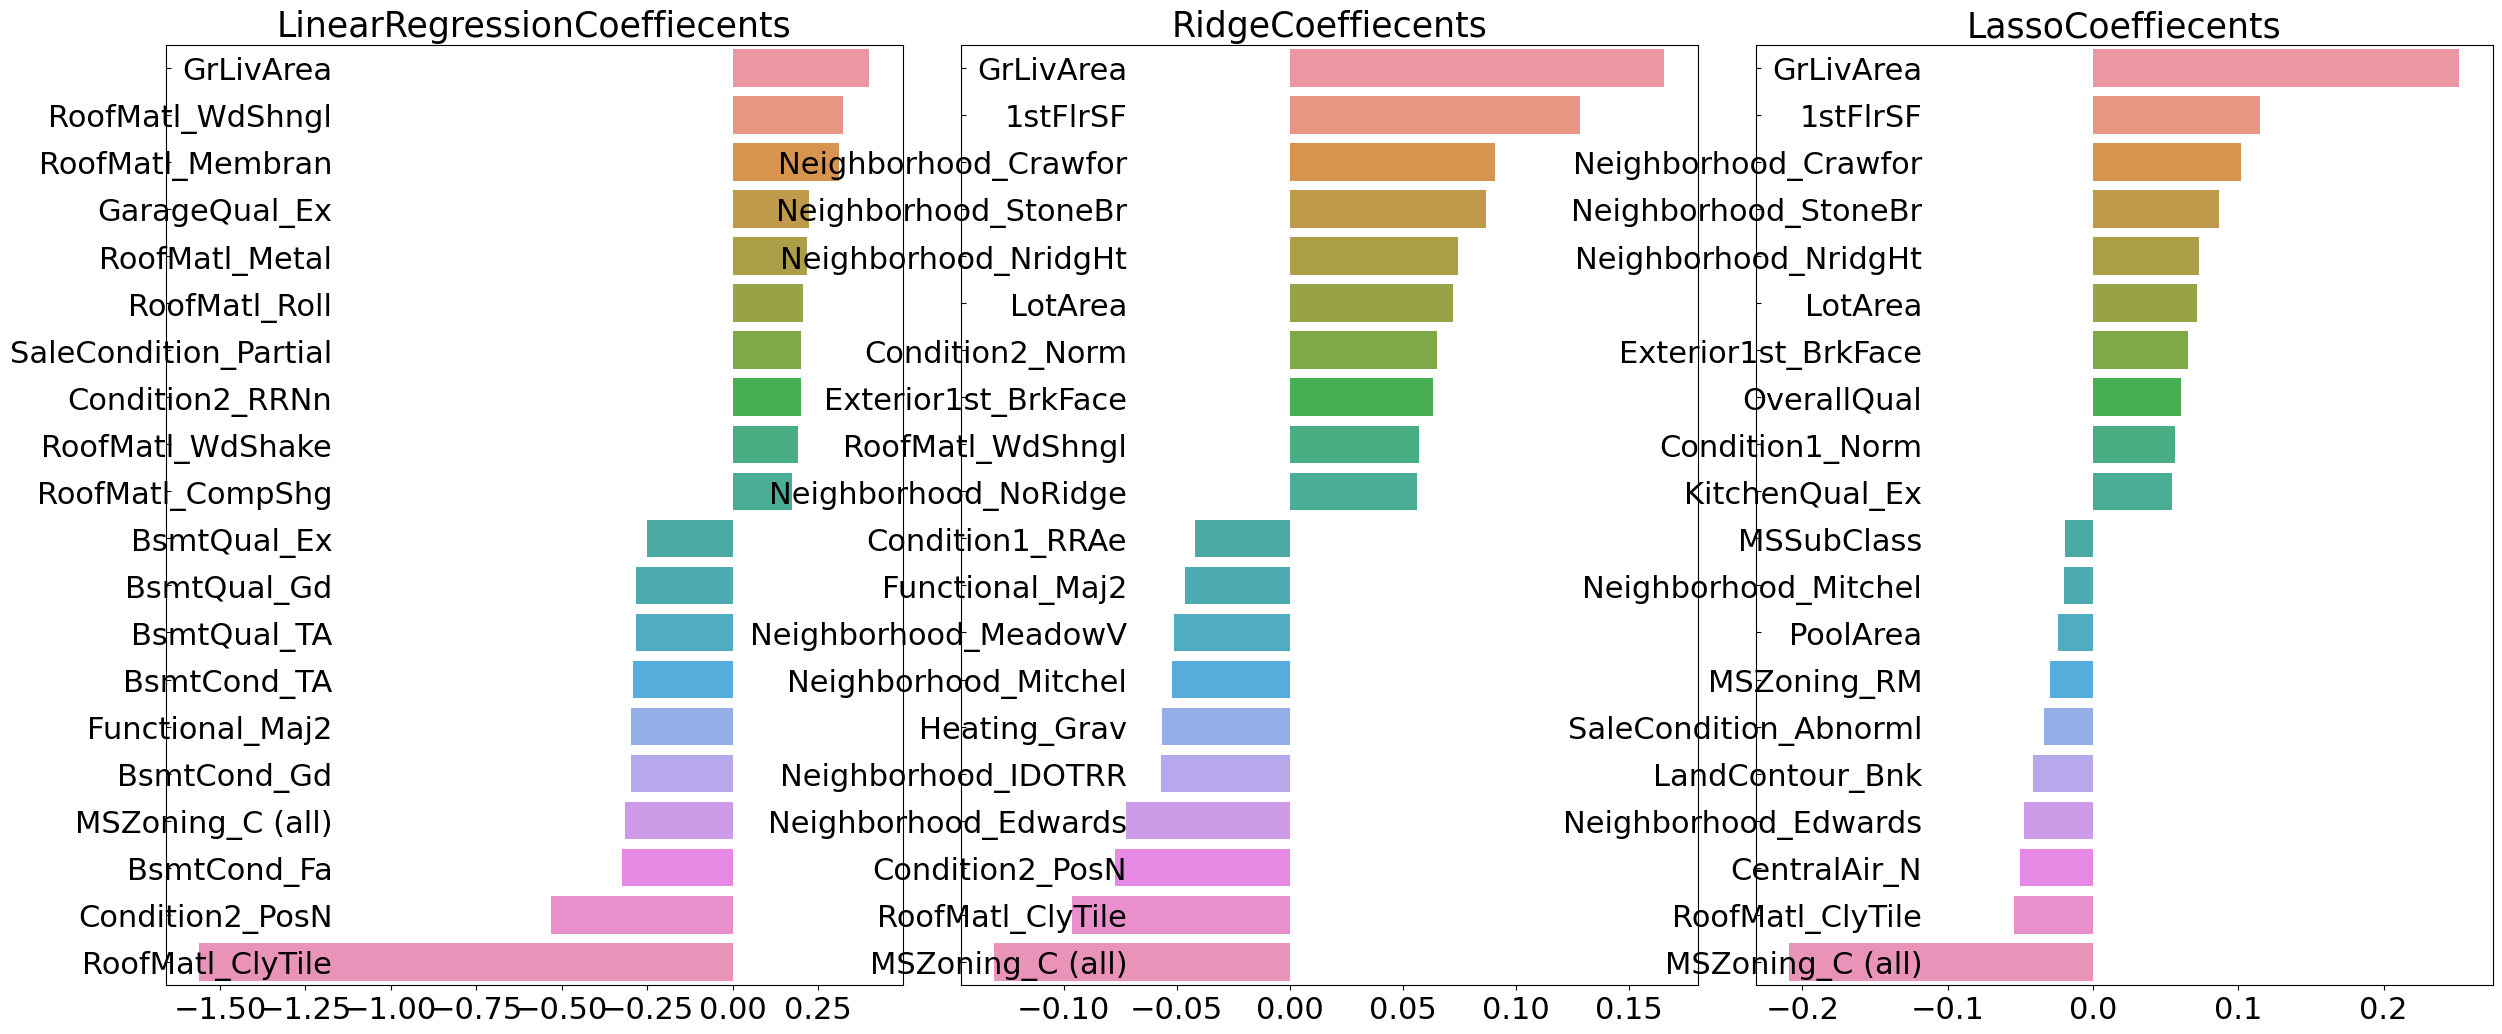

In [17]:
#다시 분리된 학습/테스트 데이터로 모델 학습, 예측, 평가 및 모델별 회귀 계수 시각화
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coef(models)

세 모델 모두 GrLivArea(거주 공간 크기)가 회귀 계수가 가장 높은 피처가 됐다.

##### 2. 이상치 데이터 처리

- 회귀 계수가 높아서 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터 처리가 중요하다

  → 세 모델 모두에서 제일 높은 회귀 계수를 가지는 GrLivArea의 데이터 분포를 살펴보자
  
  → 데이터 변환 전 house_df_org의 GrLivArea와 타겟값 SalePrice의 관계를 살펴보자


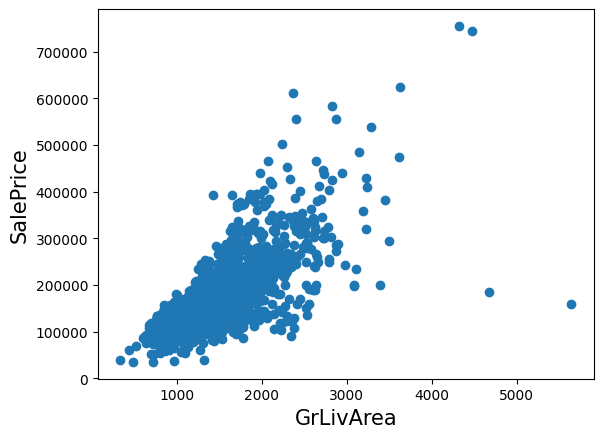

In [18]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

x축 오른편에 동떨어져있는 2개의 데이터는 일반적인 타겟값과 GrLivArea와의 관계에서 너무 어긋나있다

  → 거주 공간 크기가 가장 큰 데이터임에도 불구하고 가격이 매우 낮기 때문

따라서, GrLivArea가 4000평방피트 이상임에도 가격이 500,000달러 이하인 데이터는 이상치로 간주하고 삭제하자

In [20]:
#로그 변환을 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape', house_df_ohe.shape)

#이상치 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


업데이트된 house_df_ohe를 기반으로 피처 데이터셋과 타겟 데이터셋을 다시 생성하고 릿지와 라쏘 모델의 최적화를 수행하자

In [21]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV시 최적 평균 RMSE값:0.1122, 최적 alpha:{'alpha': 0.001}


2개의 이상치 데이터만 삭제했는데도 예측 수치가 크게 향상됐다

릿지의 경우 최적 alpha값이 10에서 8로 변했고 평균 RMSE도 0.122에서 0.1125로 개선됐다

라쏘의 경우 RMSE가 0.119에서 0.1122로 낮아졌다

GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이런 이상치를 삭제하는 것에 성능 개선에 큰 도움이 된 것이다

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


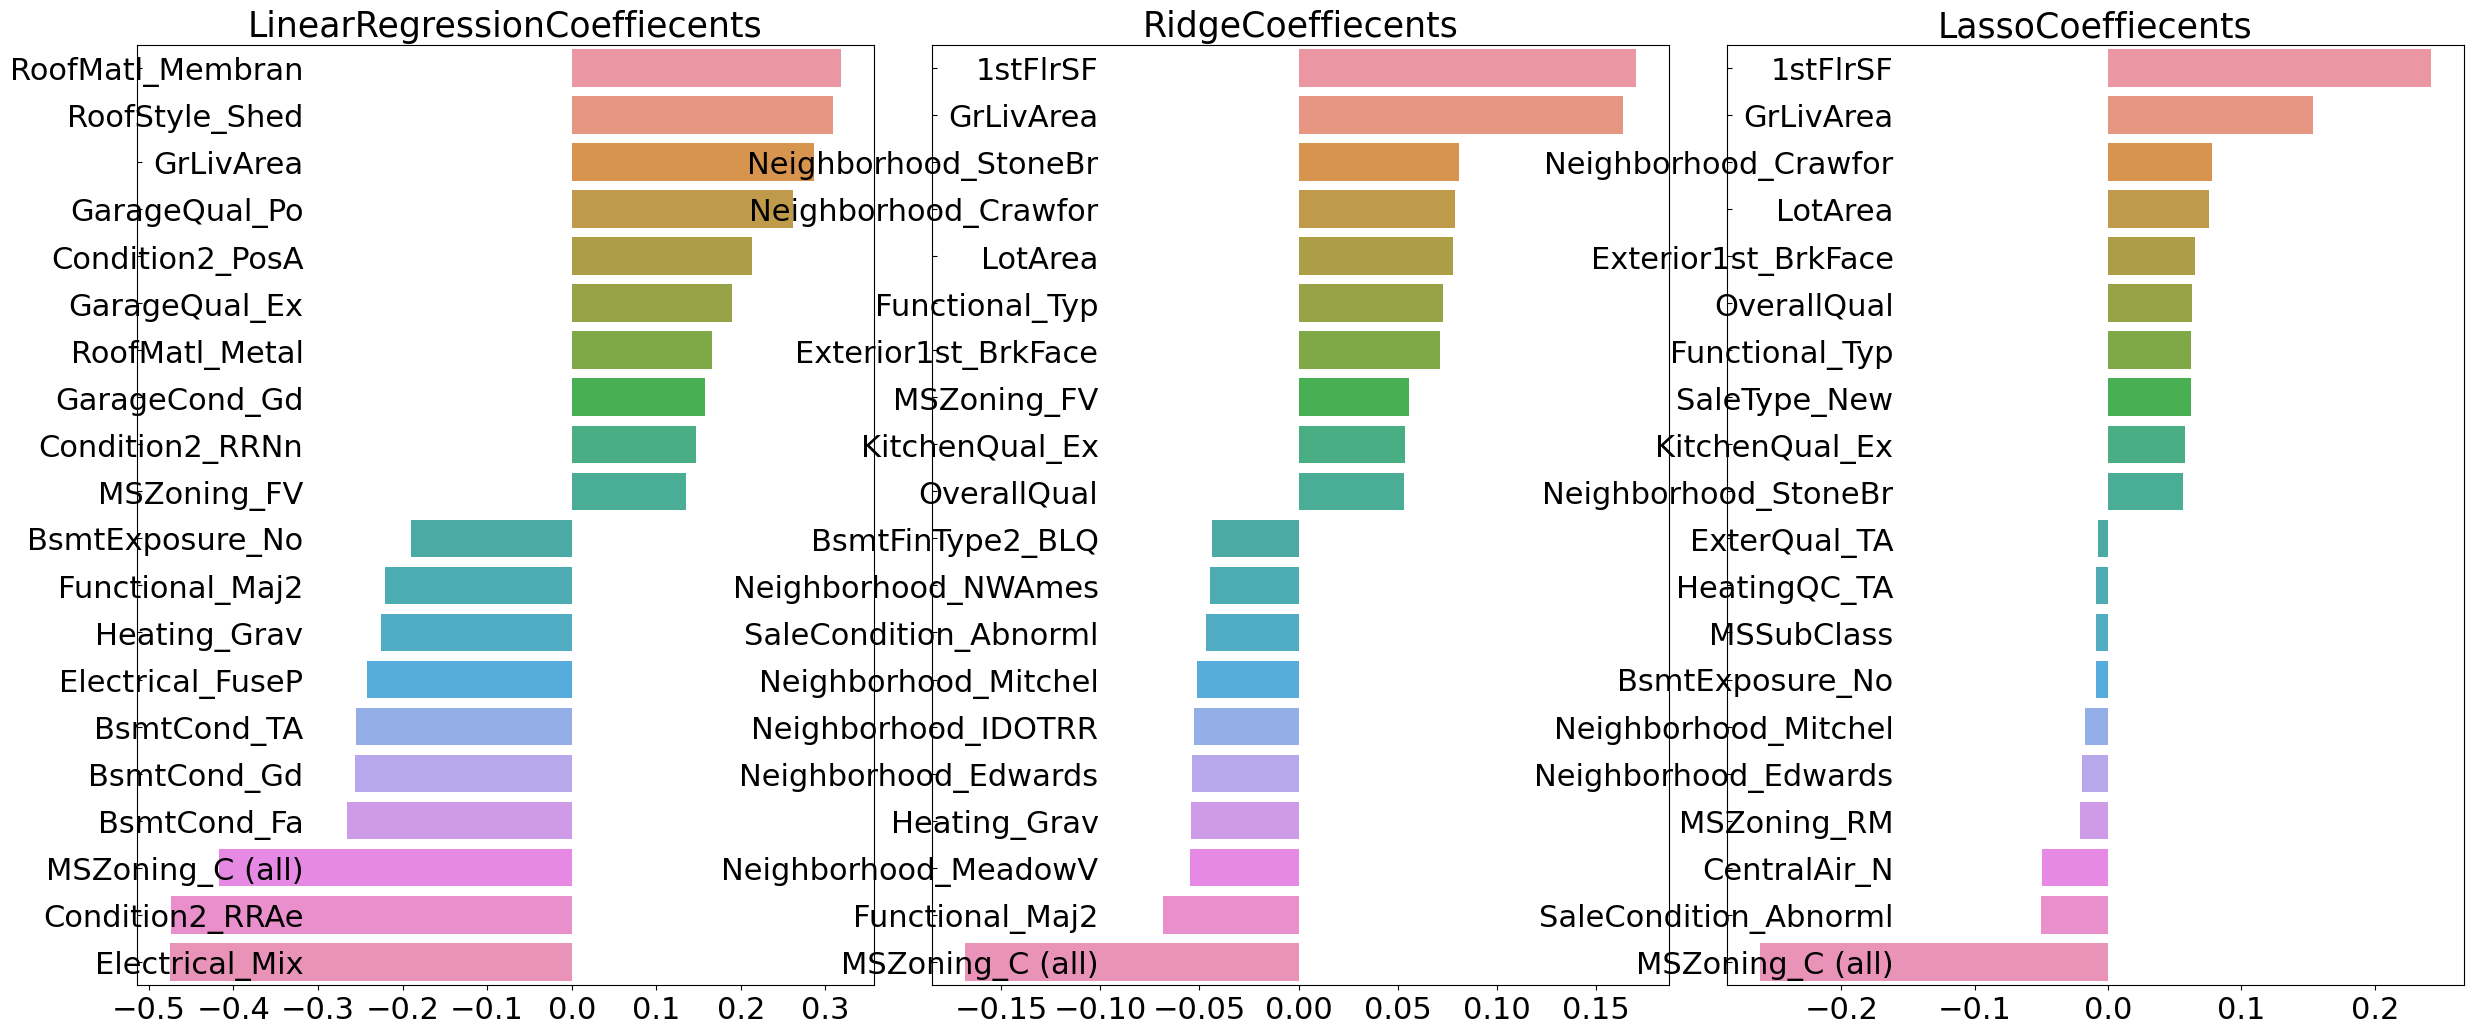

In [22]:
#이상치 제거된 데이터셋을 기반으로 분할한 데이터들의 RMSE수치 및 시각화
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coef(models)

#### 회귀 트리 모델 학습/예측/평가

- XGBoost와 LightGBM 모두 수행 시간이 오래 걸리므로 다음과 같은 하이퍼 파라미터를 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE를 구하자

In [25]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV시 최적 평균 RMSE값:0.1182, 최적 alpha:{'n_estimators': 1000}


In [26]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV시 최적 평균 RMSE값:0.1163, 최적 alpha:{'n_estimators': 1000}


In [ ]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()

    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):

        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)

        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

#### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

- 앞에서 구한 릿지와 라쏘 모델을 서로 혼합해보자

- 최종 혼합 모델, 개별 모델의 RMSE값을 출력하는 get_rmse_pred() 함수를 생성

- 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE를 구하자

In [30]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key, rmse))

#개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

#최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470506
Ridge 모델의 RMSE: 0.1034517754660323
Lasso 모델의 RMSE: 0.10024170460890035


최종 혼합 모델의 RMSE가 개별 모델보다 성능면에서는 더 개선됐다

두 개 중 성능이 조금 좋은 쪽에 가중치를 약간 더 주면 된다.

이번에는 XGBoost와 LightGBM을 혼합해보자

In [31]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10129327758047968
XGBM 모델의 RMSE: 0.10617576258589495
LGBM 모델의 RMSE: 0.10382510019327311


혼합 모델이 개별 모델 RMSE보다 조금 향상됨

#### 스태킹 앙상블 모델을 통한 회귀 예측

- 개별 모델들을 스태킹 모델로 제공하기 위한 데이터셋을 생성하는 함수 만들자

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):

        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)

        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [35]:
#위와 같은 함수는 넘파이 배열을 인자로 사용하므로 데이터프레임을 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

#각 개별 기반 모델이 생성한 학습/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


최종 메타 모델은 별도의 라쏘 모델 이용

In [36]:
stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(stack_final_X_train, y_train)
final = meta_model_lasso.predict(stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE값:', rmse)

스태킹 회귀 모델의 최종 RMSE값: 0.09751138566662847


현재까지의 모델 중 가장 좋은 성능을 보인다

스태킹은 분류뿐만 아니라 회귀에서도 효과적으로 사용될 수 있다